In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import psycopg2
import os
import sqlalchemy
from sqlalchemy import create_engine
import pipeline_plan_functions.utils.pipe_db_handler as dbh
from python_utils.utils.logger import logger
import alloc_functions.allocation_scenario as asf
import alloc_functions.controller as acf
import alloc_functions.daily as adf
import alloc_functions.cleanup as cleaner
import alloc_functions.mixed as mixed
import pipeline_plan_functions.utils.data_handler as dh
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import json
import matplotlib
from pulp import *
fps_colours = ['#004A9C', '#45D281', '#FEC001','#A365E0', '#5B9BD5',

               '#FF0000', '#0563C1', '#954F72']
import plotly.graph_objects as go
mapbox_token = ('pk.eyJ1Ijoic29mZmZ0IiwiYSI6ImNrbmZ0Z3RidzJ5NngycXA5cDNpY2c1ajIifQ.Gi2oP1Z3G5wP6pn7OF5l1A')
import pickle

### Tools

In [2]:
TIME_INT_IS = dt.timedelta(minutes=30)
N = int(dt.timedelta(days=1)/TIME_INT_IS)
POTENTIAL_TPS_IS = [i*TIME_INT_IS for i in range(N)]
TURN = 30
TP_FRACT_IS = TIME_INT_IS/dt.timedelta(hours=1)
TURN = 0
ASC_XUSE = 0.9
XPOWER = 0.97
SITE_IDS = (179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191,
            192)
def allocation_summary(allocation, drive, range_wltp, connection, cur):
    try:
        cnx = dbh.create_alch_engine()
        alloc = find_allocation(allocation, cnx)
        xmpg = alloc['xmpg']
        routes = cleaner.get_allocated_routes(allocation, connection, cur)
        routes = cleaner.get_daily_route_data(routes, alloc, connection, cur).sort_index()
        routes['category'] = 'x'
        grouped = mixed.group_routes(routes)
        charging_rate = 50*0.9
        for idx in grouped.index:
            masklist = []
            dutyR = routes[(routes['date'] == idx[0])
                                & (routes['allocated_vehicle_id'] == idx[1])].index
            # Calculate IS shifts
            for r in dutyR:
                masklist.append(mixed.tp_journeys(routes.loc[r], TURN))
            masklist.append(np.array(POTENTIAL_TPS_IS)
                                > (grouped.loc[idx, 'departure_time']-grouped.loc[idx, 'route_date']))
            masklist.append(np.array(POTENTIAL_TPS_IS)
                                < (grouped.loc[idx, 'arrival_time']-grouped.loc[idx, 'route_date']))
            n = len(masklist)
            tps = np.sum(np.vstack(masklist).sum(axis=0) == n)
            grouped.loc[idx, 'TPs'] = tps
        veh = alloc['vehicle2']
        kwh_mile = drive[veh] / xmpg  # real-world
        grouped['extra_mileage'] = grouped['TPs']*TP_FRACT_IS*charging_rate/kwh_mile
        grouped['reduced_mileage'] = (grouped['distance_miles']-grouped['extra_mileage']).clip(
            lower=grouped['IndMileage']*xmpg)

        feasible = (grouped['distance_miles'] < range_wltp[veh] * xmpg).sum()
        unfeasible_nois = ((grouped['distance_miles'] >= range_wltp[veh] * xmpg)
                         & (grouped['reduced_mileage'] < range_wltp[veh] * xmpg)).sum()
        unfeasible_withis = (grouped['reduced_mileage'] >= range_wltp[veh] * xmpg).sum()
        n_duties = len(grouped)
        n_routes = len(routes)
        n_veh = routes['allocated_vehicle_id'].max()
    except Exception as e:
        raise e
    finally:
        cnx.dispose()
    return [feasible, unfeasible_nois, unfeasible_withis, n_duties, n_routes, n_veh]
def get_site_client_id(sites, connection, cur):
    """Gets all client site IDs
    """
    try:
        sql_query = f"SELECT site_id, client_site_id FROM t_sites WHERE site_id IN {sites}"
        cur.execute(sql_query)
        connection.commit()
        sites_fetch = cur.fetchall()
        site_dict = {site[0]: site[1] for site in sites_fetch}
    except (Exception, psycopg2.Error) as error:
        logger.error("Error while fetching Site IDs")
        raise error
    return site_dict

def get_site_name_dict(sites, connection, cur):
    """Gets all client site IDs
    """
    try:
        sql_query = f"SELECT site_id, site_name FROM t_sites WHERE site_id IN {sites}"
        cur.execute(sql_query)
        connection.commit()
        sites_fetch = cur.fetchall()
        site_dict = {site[0]: site[1] for site in sites_fetch}
    except (Exception, psycopg2.Error) as error:
        logger.error("Error while fetching Site IDs")
        raise error
    return site_dict


def find_allocation(idx, cnx):
    try:
        sql_query = f"""SELECT * FROM t_allocation WHERE allocation_id={idx} LIMIT 1"""
        current_allocation = pd.read_sql_query(sql_query, cnx).iloc[0].to_dict()
    except (Exception, psycopg2.Error) as error:
        logger.error(f"Error while fetching current allocation")
        raise(error)
    return current_allocation

def find_max_demand(scenario):
    try:
        cnx = dbh.create_alch_engine()
        sql_query = f"""SELECT datetime, power_demand_kw FROM t_charge_demand WHERE scenario_id={scenario}"""
        demand = pd.read_sql_query(sql_query, con=cnx).groupby('datetime').sum()
        max_demand = demand['power_demand_kw'].max()
        demand['time'] = demand.index.time
        mode_time = demand[demand['power_demand_kw'] > max_demand*0.95]['time'].mode().loc[0]
    except (Exception, psycopg2.Error) as error:
        logger.error("Error fetching max demand")
        raise error
    finally:
        cnx.dispose()
    return max_demand, mode_time

def histo_variable(data, upperclip=None, lowerclip=None, bins=10,
                   suff='', vline_dict=None, xlim=None, ylim=None):
    fig, ax = plt.subplots(
        1, figsize=(8, 3), gridspec_kw={'hspace': 0.5})
    ax.set_title(
        f'{data.name} distribution',
        color=fps_colours[0], fontweight='bold')
    r = ax.hist(
        data.clip(upper=upperclip, lower=lowerclip),
        color=[fps_colours[0]],
        bins=bins)

    ax.set_ylabel('# of routes', color=fps_colours[0])
    ax.set_xlabel(f'{data.name}', color=fps_colours[0])
    text_pos = r[1][-1]
    if xlim:
        text_pos = xlim
    ax.text(x=text_pos*1.1, y=r[0].max()/2, s=(
        f"{len(data)} entries\n"
        f"Mean: {np.round(data.mean(), 1)}\n"
        f"Max: {np.round(data.max(), 1)}\n"
        f"Sum: {np.round(data.sum(), 1)}\n"
        f"{np.round((data > upperclip).mean()*100, 1)}% over threshold {upperclip}\n"
        f"{np.round((data < lowerclip).mean()*100, 1)}% under threshold {lowerclip}"
        ))
    ax.set_ylim(top=ylim)
    ax.set_xlim(right=xlim)
    if vline_dict:
        for i, key in enumerate(vline_dict.keys()):
            ax.axvline(x=vline_dict[key], label=key,
                       color=fps_colours[(i+1)%len(fps_colours)])
    ax.axvline(x=data.mean(), label='Mean',
               color=fps_colours[2])
    ax.legend(frameon=False)
    fig.savefig(
        f"sample/asda2/histo_{data.name}{suff}.png",
        bbox_inches="tight", dpi=300)
    return

def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

range_wltp = {
    10: 146,
    11: 185,
    33: 166,
    28: 100000,
}
drive_wltp = {
    10: 0.493150685,
    11: 0.478648649,
    33: 0.40963855,
    28: 0.153
}
colors = {
    10: fps_colours[4],
    11: fps_colours[3],
    33: fps_colours[5],
    28: fps_colours[6],
}
name = {
    10: "Maxus MR",
    11: "Maxus LR",
    33: "eTransit",
    28: "Diesel"
}
vehicles = [10, 33, 11, 28]


### Stats

In [3]:
cnx = dbh.create_alch_engine()
sql_query = f"""SELECT * FROM t_route_master WHERE site_id_start IN {SITE_IDS} AND source=1"""
routes = pd.read_sql_query(sql_query, con=cnx)
routes['date'] = pd.to_datetime(routes['departure_time'].dt.date)
routes = routes[routes['site_id_start'] == routes['site_id_end']]

In [10]:
routes['weekday'] = routes['date'].dt.weekday
distance_weekday = routes.groupby('weekday')['distance_miles'].sum().sort_values()

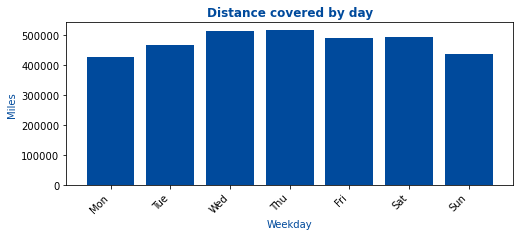

In [12]:
fig, ax = plt.subplots(
    1, figsize=(8, 3), gridspec_kw={'hspace': 0.5})
ax.set_title(
    f'Distance covered by day',
    color=fps_colours[0], fontweight='bold')
ax.bar(
    x=distance_weekday.index,
    height=distance_weekday,
    color=[fps_colours[0]])

ax.set_ylabel('Miles', color=fps_colours[0])
ax.set_xlabel('Weekday', color=fps_colours[0])
ax.xaxis.set_major_locator(matplotlib.ticker.FixedLocator(np.arange(7)))
ax.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], rotation=45, ha='right')

fig.savefig(
    f"sample/asda2/weekday_distance.png",
    bbox_inches="tight", dpi=300)

In [98]:
# Get individual route stats
agg_functions = ['count', 'mean', 'min', percentile(25), percentile(50), percentile(75), percentile(99), 'max', 'sum']
grouped_routes = routes.groupby('site_id_start')['distance_miles'].agg(agg_functions).sort_index()
grouped_routes['category'] = 'Individual routes'
grouped_routes_all = routes.groupby('client_id')['distance_miles'].agg(agg_functions).sort_index()
grouped_routes_all['category'] = 'Individual routes'
# Get the stats according to their allocation
vehicle_duties_theirs = routes.groupby(['site_id_start', 'date', 'vehicle_id']).agg({'distance_miles': 'sum', 'client_id': 'mean'})
grouped_duties_theirs = vehicle_duties_theirs['distance_miles'].groupby('site_id_start').agg(agg_functions).sort_index()
grouped_duties_theirs['category'] = 'Their allocation'
vehicle_duties_theirs_all = vehicle_duties_theirs.groupby('client_id')['distance_miles'].agg(agg_functions).sort_index()
vehicle_duties_theirs_all['category'] = 'Their allocation'

In [99]:
# Get the routes with basic diesel allocations
allocations_diesel = (369, 370, 259, 260, 261, 262, 263, 371, 265, 372, 267, 268, 373, 374)
# sql_query = f"""SELECT * FROM t_route_allocated WHERE allocation_id IN {allocations_diesel}"""
# allocated_routes = pd.read_sql_query(sql_query, con=cnx)
routes_allocated = routes[['site_id_start', 'route_id', 'distance_miles', 'client_id']].merge(
    allocated_routes[['route_id', 'date', 'allocated_vehicle_id']],
    left_on='route_id', right_on='route_id')
# Group routes into daily duties and then get stats
vehicle_duties_alloc = routes_allocated.groupby(['site_id_start', 'date', 'allocated_vehicle_id']).agg({'distance_miles': 'sum', 'client_id': 'mean'})
grouped_duties_alloc = vehicle_duties_alloc['distance_miles'].groupby('site_id_start').agg(agg_functions).sort_index()
grouped_duties_alloc['category'] = 'Our diesel allocation'
vehicle_duties_alloc_all = vehicle_duties_alloc.groupby('client_id')['distance_miles'].agg(agg_functions).sort_index()
vehicle_duties_alloc_all['category'] = 'Our diesel allocation'

In [100]:
connection, cur = dbh.database_connection('test')
site_name_dict = get_site_name_dict(SITE_IDS, connection, cur)
site_name_dict.update({5: 'All Stores'})
allsite_stats = pd.concat([grouped_routes, grouped_duties_theirs, grouped_duties_alloc,
                           grouped_routes_all, vehicle_duties_theirs_all, vehicle_duties_alloc_all], axis=0)
allsite_stats['Site name'] = allsite_stats.index.map(site_name_dict)
allsite_stats.to_csv('sample/asda2/asda_allsite_distancestats.csv')
cur.close()
connection.close()
cnx.dispose()

### Long Route maps

In [90]:
route_id = 1316645
depot_loc = [52.6754, -2.4524]
site_name = 'Telford'
# route_id = 1229679
# depot_loc = [52.7083, -2.4329]
# site_name = 'Donnington Wood'

# route_id = 1316131
# depot_loc = [52.6754, -2.4524]
# site_name = 'Telford'
# route_id = 1315444
# depot_loc = [52.6754, -2.4524]
# site_name = 'Telford'

# route_id = 1302661
# depot_loc = [52.7055, -2.742]
# site_name = 'Shrewsbury'

sql_query = f"SELECT * FROM t_telematics WHERE route_id = {route_id}"
telematics = pd.read_sql_query(sql_query, con=cnx)
telematics.sort_values(by='departure_time', inplace=True)
pickle.dump(telematics, open(f'sample/asda2/telematics_route_{route_id}.pkl', 'wb'))
telematics.head()

,client_id,site_id,departure_time,arrival_time,departure_location,departure_longitude,departure_latitude,arrival_location,arrival_longitude,arrival_latitude,vehicle_id,distance_miles,route_id,journey_node_id,journey_type,driving_time,run,departure_site_id,arrival_site_id
1,5,None,2021-03-21 08:02:13,2021-03-21 08:07:46,None,-2.452401,52.675806,None,-2.481187,52.672840,7085,1.740211,1316645,14604903,None,None,45,190,-1
2,5,None,2021-03-21 08:12:30,2021-03-21 08:14:31,None,-2.481181,52.672848,None,-2.482963,52.675973,7085,0.559354,1316645,14604904,None,None,45,-1,-1
3,5,None,2021-03-21 08:14:52,2021-03-21 08:30:46,None,-2.482981,52.675953,None,-2.757636,52.682576,7085,13.113735,1316645,14604905,None,None,45,-1,-1
4,5,None,2021-03-21 08:30:48,2021-03-21 08:37:59,None,-2.757636,52.682576,None,-2.796137,52.702685,7085,4.039776,1316645,14604906,None,None,45,-1,-1
5,5,None,2021-03-21 08:38:03,2021-03-21 08:38:13,None,-2.796143,52.702687,None,-2.796053,52.702737,7085,0.000000,1316645,14604907,None,None,45,-1,-1


In [93]:
telematics['time'] = telematics['departure_time'].astype(str).str[11:16]
lats = telematics['departure_latitude'].to_list() + [telematics['departure_latitude'].iloc[-1]]
lons = telematics['departure_longitude'].to_list() + [telematics['departure_longitude'].iloc[-1]]
times = telematics['time'].to_list() + [str(telematics['arrival_time'].iloc[-1])[:5]]
fig = go.Figure()

fig.add_trace(go.Scattermapbox(
    mode = "lines+markers", name=route_id,
    line=dict(color='black', width=3),
    lon = lons,
    lat = lats,
    marker=dict(symbol ='circle', size=8, opacity=1, color=fps_colours[0]),
    text=times
    ),)
fig.add_trace(go.Scattermapbox(
    mode = "markers", name=site_name,
    lon = [depot_loc[1]],
    lat = [depot_loc[0]],
    marker=dict(symbol ='circle', size=20, opacity=1, color=fps_colours[3])))


fig.update_mapboxes(
    accesstoken=mapbox_token)
fig.update_layout(
    autosize=True, width=500, height=400,
    margin={"r":0,"t":50,"l":10,"b":0}, hovermode="x",
    title=f"{route_id} - {site_name}")
fig.update_mapboxes(
    center=dict(lat=(min(lats)+max(lats))/2,
                lon=(min(lons)+max(lons))/2),
    zoom=8, style="streets")
fig.write_html(f"sample/asda2/map_{route_id}.html")
fig.write_image(f"sample/asda2/map_{route_id}.png", scale=3)

fig.show()

### TCO Maxus

In [3]:
scenarios = pickle.load(open('sample/asda2/scenarios_feasibility.pkl', 'rb'))
scenarios.set_index('scenario_id', inplace=True)
# maxus_scenarios = scenarios[scenarios['vehicle_type'] == 'Maxus MR'][['allocation_id', 'site_id']].copy().reset_index()
# site_scenario_mr_dict = maxus_scenarios.set_index('site_id')['scenario_id'].to_dict()
# site_alloc_mr_dict = maxus_scenarios.set_index('site_id')['allocation_id'].to_dict()

In [32]:
connection, cur = dbh.database_connection('test')
cnx = dbh.create_alch_engine()

list_df = []
for allocation in maxus_scenarios['allocation_id']:
    print(allocation)
    alloc = find_allocation(allocation, cnx)
    routes = cleaner.get_allocated_routes(allocation, connection, cur)
    routes = cleaner.get_daily_route_data(routes, alloc, connection, cur).sort_index()

    site_grouped = routes.groupby('allocated_vehicle_id').agg({
        'allocation_id': 'mean',
        'distance_miles': 'sum',
    })
    list_df.append(site_grouped.reset_index())
tco_table = pd.concat(list_df)
tco_table = tco_table.merge(maxus_scenarios, how='left', left_on='allocation_id', right_on='allocation_id')
tco_table.to_csv('sample/asda2/tco_table_maxusmr.csv')
cur.close()
cnx.dispose()
connection.close()

355
356
357
411
359
360
361
362
363
364
365
413
367
368


In [40]:
tco_mr = pd.read_csv('sample/asda2/tco_mr.csv')
dbh.upload_table(tco_mr, 't_vehicle_tco_components')

2022-05-27 12:16:20|DEBUG|pipe_db_handler.py(62)|upload_table|Uploaded to t_vehicle_tco_components


In [50]:
# tco_charger_lr = pd.read_sql("SELECT * FROM t_charger_tco_components WHERE scenario_id IN (340, 341, 342, 343, 344, 345, 346, 347, 376, 377, 378, 379, 380, 381)", con=cnx)
tco_charger_mr = tco_charger_lr.copy()
tco_charger_mr['scenario_id'] = tco_charger_mr['site_id'].map(site_scenario_mr_dict)
tco_charger_mr['allocation_id'] = tco_charger_mr['site_id'].map(site_alloc_mr_dict)
tco_charger_mr['run_id'] = 181
dbh.upload_table(tco_charger_mr, 't_charger_tco_components')
tco_charger_mr

2022-05-27 12:21:34|DEBUG|pipe_db_handler.py(62)|upload_table|Uploaded to t_charger_tco_components


,scenario_id,allocation_id,run_id,client_id,site_id,n_units,purchase_price,purchase_price_w_grant,annual_maintenance_cost,power,annual_monitoring_cost,annual_optimisation_cost,upfront_lease_cost,dashboard
0,426,360,181,5,184,0,0,0,0,0.0,0,0,0.0,1
1,426,360,181,5,184,18,56628,56628,3330,11.0,4320,4320,5663.0,1
2,425,359,181,5,183,0,0,0,0,0.0,0,0,0.0,1
3,425,359,181,5,183,13,40898,40898,2405,11.0,3120,3120,4090.0,1
4,434,411,181,5,182,0,0,0,0,0.0,0,0,0.0,1
5,434,411,181,5,182,15,47190,47190,2775,11.0,3600,3600,4719.0,1
6,429,363,181,5,187,0,0,0,0,0.0,0,0,0.0,1
7,429,363,181,5,187,5,13335,13335,925,11.0,1200,1200,1334.0,1
8,427,361,181,5,185,0,0,0,0,0.0,0,0,0.0,1
9,427,361,181,5,185,18,56628,56628,3330,11.0,4320,4320,5663.0,1


### Create summaries

In [3]:
cnx = dbh.create_alch_engine()
connection, cur = dbh.database_connection('test')
sql_query = f"""SELECT scenario_id, allocation_id, smart_charging, output_kwh FROM t_charging_scenarios WHERE run_id IN (44, 45, 46, 47)"""
scenarios = pd.read_sql_query(sql_query, con=cnx)
allocation_ids = scenarios['allocation_id'].unique()
sql_query = f"""SELECT allocation_id, site_id, xmpg, charger2, vehicle2, num_r, num_vehicle2, num_charger2
    FROM t_allocation WHERE allocation_id IN {tuple(allocation_ids)}"""
alloc_summary = pd.read_sql_query(sql_query, cnx)
cnx.dispose()


In [4]:
alloc_summary['diesel'] = alloc_summary['vehicle2'] == 28
alloc_summary['sad'] = alloc_summary['xmpg'] <0.7
alloc_summary['best_ev'] = False
alloc_summary.loc[alloc_summary['vehicle2'] == 33, 'best_ev'] = True

normal_allocations = alloc_summary[(~alloc_summary['best_ev'])]
opt_allocations = alloc_summary[(alloc_summary['best_ev'])]
count_summary = alloc_summary.groupby('site_id').agg({
    'allocation_id': 'count', 'vehicle2': 'nunique', 'sad': 'sum', 'diesel': 'sum'
})
print("all the same:", (count_summary.nunique() == 1).all())
print("Allocations except best EV:\n", normal_allocations['allocation_id'].to_list())
print("Allocations best EV:\n", opt_allocations['allocation_id'].to_list())
### Maxus MR allocations
mr_allocations = alloc_summary[alloc_summary['vehicle2'] == 10]['allocation_id'].to_list()
print('Maxus MR allocations:', mr_allocations)
scenarios = scenarios.merge(alloc_summary, how='left')

scenarios['type'] = ''

scenarios.loc[(scenarios['vehicle2'] == 28)
              & (scenarios['xmpg'] == 0.79),
              'type'] = 'Diesel baseline'
scenarios.loc[(scenarios['vehicle2'] == 28)
              & (scenarios['xmpg'] == 0.541),
              'type'] = 'Diesel baseline low range'
scenarios.loc[(scenarios['vehicle2'] == 11)
              & (scenarios['xmpg'] == 0.79),
              'type'] = 'EV baseline'
scenarios.loc[(scenarios['vehicle2'] == 10)
              & (scenarios['xmpg'] == 0.685)
              & (scenarios['charger2'] == 11),
              'type'] = 'EV baseline low range'
scenarios.loc[(scenarios['vehicle2'] == 10)
              & (scenarios['xmpg'] == 0.685)
              & (scenarios['charger2'] == 50),
              'type'] = 'EV Optimal low range'
scenarios.loc[(scenarios['best_ev'])
              & (scenarios['smart_charging']),
              'type'] = 'EV Optimal smart charging on'
scenarios.loc[(scenarios['best_ev'])
              & (~scenarios['smart_charging']),
              'type'] = 'EV Optimal smart charging off'
scenarios.loc[(scenarios['vehicle2'] == 10)
              & (scenarios['xmpg'] == 0.79),
              'type'] = 'Maxus MR'
sites = tuple(scenarios['site_id'].unique())
site_dict = get_site_client_id(sites, connection, cur)
scenarios['client_site_id'] = scenarios['site_id'].map(site_dict)
diesel_scenarios = scenarios[scenarios['type'] == 'Diesel baseline'][['allocation_id', 'site_id', 'num_r']]
scenarios = scenarios.merge(diesel_scenarios, how='left', left_on='site_id', right_on='site_id', suffixes=("", "_diesel"))
scenarios['r_removed'] = scenarios['num_r_diesel'] - scenarios['num_r']
scenarios['r_removed%'] = 100*scenarios['r_removed'] / scenarios['num_r_diesel']
scenarios.sort_values(by='scenario_id', inplace=True)
site_name_dict = get_site_name_dict(sites, connection, cur)
scenarios['site_name'] = scenarios['site_id'].map(site_name_dict)
dict_types_deck = {'EV Optimal smart charging on': 'eTransit',
                   'EV Optimal smart charging off': 'eTransit',
                   'EV Optimal low range': 'Asda Spec',
                   'Maxus MR': 'Maxus MR',
                   'EV baseline': 'Maxus LR',
                   'Diesel baseline': 'Sprinter',
                   'EV baseline low range': 'Asda Spec'}
scenarios['vehicle_type'] = scenarios['type'].map(dict_types_deck)
scenarios.to_csv('sample/asda2/scenarios.csv')

all the same: True
Allocations except best EV:
 [390, 304, 303, 364, 301, 302, 263, 374, 262, 265, 305, 259, 389, 268, 378, 379, 260, 282, 276, 371, 307, 277, 383, 273, 343, 413, 391, 410, 384, 381, 373, 385, 382, 261, 288, 309, 296, 310, 275, 274, 287, 267, 361, 357, 360, 359, 365, 281, 279, 349, 346, 345, 351, 352, 344, 347, 377, 375, 376, 367, 362, 369, 370, 387, 392, 388, 406, 407, 380, 405, 408, 409, 355, 356, 411, 368, 372, 386, 290, 289, 295, 293, 291, 363]
Allocations best EV:
 [335, 333, 332, 331, 338, 337, 403, 401, 404, 330, 329, 399, 400, 402]
Maxus MR allocations: [390, 304, 303, 364, 301, 302, 305, 389, 307, 343, 413, 391, 410, 309, 310, 361, 357, 360, 359, 365, 349, 346, 345, 351, 352, 344, 347, 367, 362, 387, 392, 388, 406, 407, 405, 408, 409, 355, 356, 411, 368, 363]


In [89]:
routes_removed_table = scenarios[scenarios['type'].isin(dict_types_deck.keys())][['site_name', 'vehicle_type', 'r_removed', 'r_removed%']]
routes_removed_table.set_index(['site_name', 'vehicle_type'], inplace=True)
routes_removed_table = routes_removed_table.sort_index().unstack()
routes_removed_table.to_csv('sample/asda2/routes_removed.csv')

### Feasibility

In [114]:
# For scenario, caculate allocation_summary
# [feasible, unfeasible_nois, unfeasible_withis, n_duties, n_routes, n_veh]
cols = ['n_feasible', 'n_unfeasible_nois', 'n_unfeasible_withis', 'n_duties', 'n_routes', 'n_veh']
# for c in cols:
#     scenarios[c] = 0

feasibility_index = scenarios[~scenarios['vehicle_type'].isna()].index
for idx in feasibility_index[42:]:
    print(scenarios.loc[idx, ['site_name', 'vehicle_type']].values)
    stats = allocation_summary(scenarios.loc[idx, 'allocation_id'], drive_wltp, range_wltp, connection, cur)
    scenarios.loc[idx, cols] = stats

scenarios['feasible_without_pc'] = 100 * scenarios['n_feasible'] / scenarios['n_duties']
scenarios['feasible_with_pc'] = 100 * (scenarios['n_unfeasible_nois'] + scenarios['n_unfeasible_withis']) / scenarios['n_duties']
scenarios.sort_values(by='site_name', inplace=True)
scenarios.to_csv('sample/asda2/scenarios_feasibility.csv')

pickle.dump(scenarios, open('scenarios_feasibility.pkl', 'wb'))

['Bloxwich' 'Maxus MR']
['Brierley Hill (New Store)' 'Maxus MR']
['Chelmsley Wood' 'Maxus MR']
['Dudley Merry Hill' 'Maxus MR']
['Great Bridge Supercentre' 'Maxus MR']
['Minworth Supercentre' 'Maxus MR']
['Queslett' 'Maxus MR']
['Shrewsbury' 'Maxus MR']
['Small Heath' 'Maxus MR']
['St Matthews (Walsall)' 'Maxus MR']
['Tipton' 'Maxus MR']
['Wolverhampton' 'Maxus MR']
['Donnington Wood' 'Maxus MR']
['Telford' 'Maxus MR']


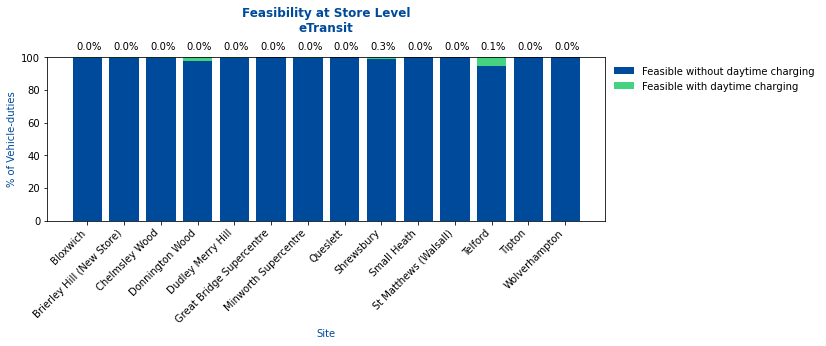

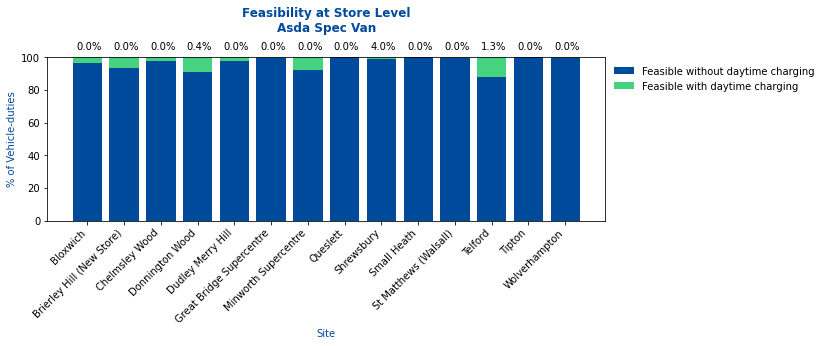

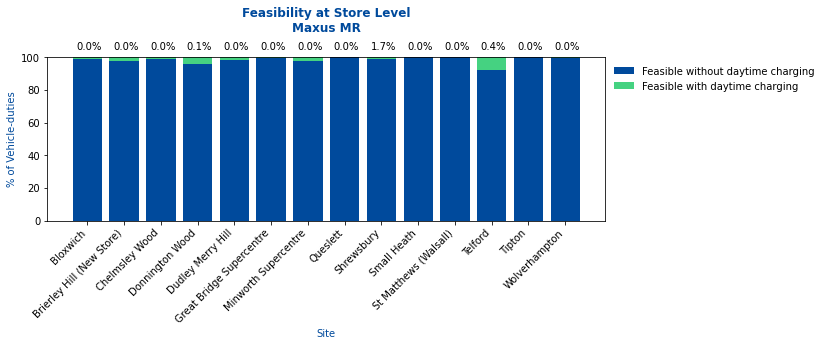

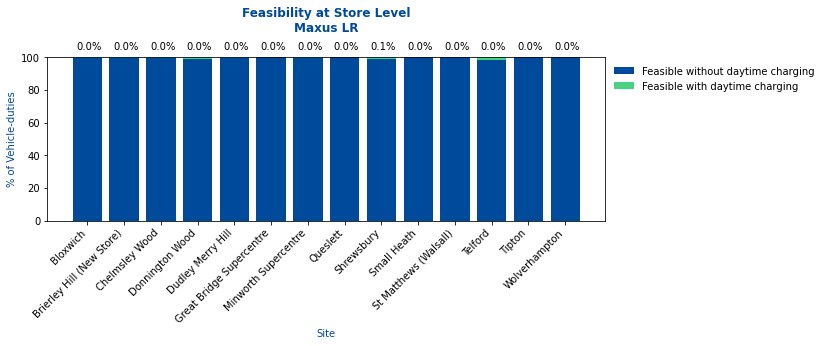

In [177]:
for vehicle_type in dict_types_deck.values():
    fig, ax = plt.subplots(1, figsize=(10, 3))
    cols = ['feasible_without_pc', 'feasible_with_pc', 'r_removed%']
    scenarios_vehicle = scenarios[scenarios['vehicle_type'] == vehicle_type][cols].values
    xlabels = scenarios[scenarios['vehicle_type'] == vehicle_type]['site_name'].values
    N = len(xlabels)
    ax.bar(x = xlabels,
        height=scenarios_vehicle[:, 0],
        color=[fps_colours[0]], label='Feasible without daytime charging')
    ax.bar(x = xlabels,
        height=scenarios_vehicle[:, 1],
        bottom=scenarios_vehicle[:, 0],
        color=[fps_colours[1]], label='Feasible with daytime charging')
    ax.legend(frameon=False, bbox_to_anchor=(1, 1))
    ax.set_xlabel('Site', color=fps_colours[0])
    ax.xaxis.set_major_locator(matplotlib.ticker.FixedLocator(np.arange(N)))
    ax.set_xticklabels(xlabels, rotation=45, ha='right')
    ax.set_ylabel(r'% of Vehicle-duties', color=fps_colours[0])
    for i in range(N):
        ax.text(i-0.3, 105, f"{np.round(scenarios_vehicle[i, 2], 1)}%")
    ax.set_title(
        f"Feasibility at Store Level"
        f"\n{vehicle_type}",
        color=fps_colours[0], fontweight='bold', y=1.12)
    fig.savefig(
        f"sample/asda2/feasibility_alloc{vehicle_type}.png",
        bbox_inches="tight", dpi=300)
    # break

### Charging load

In [5]:
# scenarios = pickle.load(open('sample/asda2/scenarios_feasibility.pkl', 'rb'))
scenarios.set_index('scenario_id', inplace=True)

In [14]:
# scenario_ids_load = [395, 397, 399, 401, 403, 405, 407, 409, 411, 413, 415, 417, 419, 421]
scenario_ids_load = scenarios[scenarios['output_kwh'] > 0].index
col_demand_kw = 'unmanaged_kw_max'
col_time_max = 'unmanaged_time_maxdemand'
col_demand_kva = 'unmanaged_kva_max'

# scenarios[col_demand_kw] = 0
# scenarios[col_time_max] = dt.time(0)
for s in scenario_ids_load[32:]:
    print(s)
    scenarios.loc[s, [col_demand_kw, col_time_max]] = find_max_demand(s)

398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479


In [15]:
scenarios[col_demand_kva] = scenarios[col_demand_kw]/XPOWER
scenarios[f"{col_demand_kw} - 20% eq"] = (scenarios[col_demand_kw] * 0.8)/ASC_XUSE
# scenarios[f"{col_demand_kw} - 10% eq"] = (scenarios[col_demand_kw] * 0.9)/ASC_XUSE
scenarios.to_csv('sample/asda2/scenarios_demand.csv')

In [ ]:
scenarios[['scenario_id', 'allocation_id', 'site_id', 'xmpg',
       'charger2', 'vehicle2', 'num_r', 'num_vehicle2', 'num_charger2',
       'allocation_id_diesel', 'num_r_diesel', 'r_removed', 'r_removed%',
       'n_feasible', 'n_unfeasible_nois',
       'n_unfeasible_withis', 'n_duties', 'n_routes', 'n_veh']]

,scenario_id,allocation_id,site_id,xmpg,charger2,vehicle2,num_r,num_vehicle2,num_charger2,allocation_id_diesel,num_r_diesel,r_removed,r_removed%,n_feasible,n_unfeasible_nois,n_unfeasible_withis,n_duties,n_routes,n_veh
51,364,369,179,0.790,50,28,6383,8,0,369,6383,0,0.0,0,0,0,0,0,0
57,370,375,179,0.541,50,28,6383,8,0,369,6383,0,0.0,0,0,0,0,0,0
63,376,381,179,0.790,11,11,6383,8,8,369,6383,0,0.0,2836,1,0,2837,6383,8
0,422,355,179,0.790,50,10,6383,8,0,369,6383,0,0.0,2808,27,1,2836,6383,8
91,410,399,179,0.790,50,33,6383,8,0,369,6383,0,0.0,2830,6,0,2836,6383,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11,433,368,192,0.790,50,10,15133,17,0,374,15133,0,0.0,5643,5,3,5651,15133,17
62,375,380,192,0.541,50,28,15133,17,0,374,15133,0,0.0,0,0,0,0,0,0
56,369,374,192,0.790,50,28,15133,17,0,374,15133,0,0.0,0,0,0,0,0,0
74,393,410,192,0.541,50,11,15133,17,2,374,15133,0,0.0,0,0,0,0,0,0


### Duty allocation Histos

134528


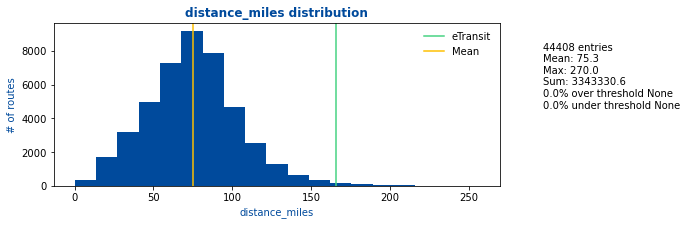

In [107]:
# sql_query = f"""SELECT *  FROM t_route_master
#     WHERE site_id_start IN (179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192)
#     AND source=1"""
# routes = pd.read_sql_query(sql_query, cnx)
# routes['date'] = pd.to_datetime(routes['departure_time'].dt.date)
# duties_unallocated = routes.groupby(['site_id_start', 'date', 'vehicle_id'])['distance_miles'].sum()
print(len(routes))
histo_variable(duties_unallocated, suff='_unallocated', xlim=270, bins=20, vline_dict={'eTransit': range_wltp[v]})

134528


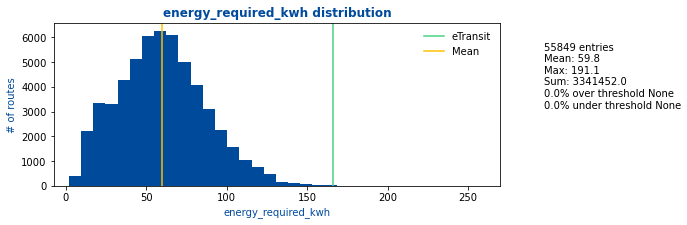

In [108]:
# allocations_transit = tuple(scenarios[scenarios['type'] == 'EV Optimal smart charging on']['allocation_id'])
# sql_query = f"""SELECT *  FROM t_route_allocated
#     WHERE allocation_id IN {allocations_transit}"""
# routes = pd.read_sql_query(sql_query, cnx)
# duties_allocated = routes.groupby(['allocation_id', 'date', 'allocated_vehicle_id'])['energy_required_kwh'].sum()
# v = routes['allocated_spec_id'].mode()[0]
# xmpg = 0.79
# drive = drive_wltp[v] / xmpg
# duties_allocated_miles = duties_allocated / drive
print(len(routes))
histo_variable(duties_allocated_miles, suff=f'_allocated_{v}', xlim=270, bins=25, vline_dict={'eTransit': range_wltp[v]})

### Allocate

In [8]:
cnx = dbh.create_alch_engine()
connection, cur = dbh.database_connection('test')
idx = 372
sql_query = f"""SELECT * FROM t_route_allocated WHERE allocation_id={idx}"""
routes = pd.read_sql_query(sql_query, con=cnx, index_col='route_id')
orig_routes = adf.get_routes_fromid(routes.index, 't_route_master',
                                    1, connection, cur)
route_cols = ['departure_time', 'arrival_time', 'distance_miles',
                'payload', 'number_crates']
routes = routes.merge(orig_routes[route_cols], left_index=True,
                        right_index=True)
routes['hour_starts'] = ((pd.to_datetime(routes['departure_time'])
                         -pd.to_datetime(routes['departure_time'].dt.date))
                         / np.timedelta64(1, 'h'))
routes.loc[routes['shift'] == 1, 'route_cost'] = 1
vJourneys = routes.groupby(['date', 'allocated_vehicle_id']).agg({'departure_time': 'min',
                    'arrival_time': 'max',
                    'shift': 'count',
                    'route_cost': 'min',
                    'energy_required_kwh': 'sum'})

In [9]:

cnx = dbh.create_alch_engine()
sql_query = f"""SELECT * FROM t_route_master WHERE client_id = 5"""
routes = pd.read_sql_query(sql_query, con=cnx)
routes['hour_starts'] = ((pd.to_datetime(routes['departure_time'])
                         -pd.to_datetime(routes['departure_time'].dt.date))
                         / np.timedelta64(1, 'h'))

In [10]:
# cnx = dbh.create_alch_engine()
sql_query = f"""SELECT site_id, num_r, vehicle2 FROM t_allocation WHERE run_id IN (168, 171)"""
allocations = pd.read_sql_query(sql_query, con=cnx)

In [11]:
df = allocations.groupby('site_id').agg({'num_r': ['min', 'max']})
df.columns = ['n_routes_sad', 'n_routes_diesel']
df['% removed'] = 100*(df['n_routes_diesel'] - df['n_routes_sad'])/df['n_routes_diesel']
df

,n_routes_sad,n_routes_diesel,% removed
site_id,,,
179,6380,6383,0.047000
180,8823,8837,0.158425
181,0,10197,100.000000
182,10708,10747,0.362892
183,11421,11421,0.000000
184,17262,17262,0.000000
185,13403,13405,0.014920
186,6189,6189,0.000000
187,0,940,100.000000


In [12]:
connection, cur = dbh.database_connection('test')
sql_query = f"""SELECT *  FROM t_route_master
    WHERE client_id=5
    AND source = 1"""
cur.execute(sql_query)
connection.commit()
routes_fetch = cur.fetchall()
desc = cur.description
column_names = [col[0] for col in desc]
cur.close()
connection.close()

(array([4.8300e+02, 7.1150e+03, 2.0186e+04, 2.9882e+04, 2.5972e+04,
        1.6833e+04, 1.1548e+04, 7.2310e+03, 4.7980e+03, 3.3030e+03,
        2.2950e+03, 1.4670e+03, 1.0520e+03, 7.4600e+02, 4.7100e+02,
        3.2700e+02, 2.2800e+02, 1.7600e+02, 1.3000e+02, 1.0900e+02,
        5.0000e+01, 4.0000e+01, 3.9000e+01, 2.3000e+01]),
 array([  0,   5,  10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,
         65,  70,  75,  80,  85,  90,  95, 100, 105, 110, 115, 120]),
 <BarContainer object of 24 artists>)

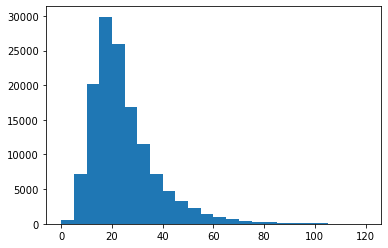

In [13]:
plt.hist(routes['distance_miles'], bins=5*np.arange(0, 25))

### Manage Runs

In [14]:
def find_runs(runs, cnx):
    try:
        sql_query = f"""SELECT * FROM t_run_allocation WHERE run_id IN {runs}"""
        run_table = pd.read_sql_query(sql_query, cnx)
    except (Exception, psycopg2.Error) as error:
        logger.error(f"Error fetching run data")
        raise(error)
    return run_table

runs = tuple(np.arange(168, 175))
# runs = '(82)'
new_start_run = 176

cnx = dbh.create_alch_engine()
run_table = find_runs(runs, cnx)
run_table['sites'] = '[179, 180, 186, 188, 191, 192]'
run_id_diff = run_table['run_id'] - run_table['run_id'].min()
run_table['run_id'] = new_start_run + run_id_diff
dbh.upload_table(run_table, 't_run_allocation')
cnx.dispose()
run_table

2022-05-26 08:45:25|INFO|pipe_db_handler.py(64)|upload_table|Error uploading table to t_run_allocation


IntegrityError: (psycopg2.errors.UniqueViolation) duplicate key value violates unique constraint "t_run_allocation_pkey"
DETAIL:  Key (run_id)=(176) already exists.

[SQL: INSERT INTO t_run_allocation (run_id, client_id, allocation_app, allocation_version, sites, start_date, end_date, vehicles, xmpg_change, chargers, route_table, cap_vehicles, mixed_fleet, source, num_v) VALUES (%(run_id)s, %(client_id)s, %(allocation_app)s, %(allocation_version)s, %(sites)s, %(start_date)s, %(end_date)s, %(vehicles)s, %(xmpg_change)s, %(chargers)s, %(route_table)s, %(cap_vehicles)s, %(mixed_fleet)s, %(source)s, %(num_v)s)]
[parameters: ({'run_id': 176, 'client_id': 5, 'allocation_app': 'allocate.py', 'allocation_version': None, 'sites': '[179, 180, 186, 188, 191, 192]', 'start_date': datetime.datetime(2020, 12, 3, 0, 0), 'end_date': datetime.datetime(2021, 12, 3, 0, 0), 'vehicles': '[[], [28]]', 'xmpg_change': -21.0, 'chargers': '[22, 50]', 'route_table': 't_route_master', 'cap_vehicles': False, 'mixed_fleet': '[]', 'source': 1, 'num_v': None}, {'run_id': 177, 'client_id': 5, 'allocation_app': 'allocate.py', 'allocation_version': None, 'sites': '[179, 180, 186, 188, 191, 192]', 'start_date': datetime.datetime(2020, 12, 3, 0, 0), 'end_date': datetime.datetime(2021, 12, 3, 0, 0), 'vehicles': '[[], [28]]', 'xmpg_change': -51.3, 'chargers': '[22, 50]', 'route_table': 't_route_master', 'cap_vehicles': False, 'mixed_fleet': '[]', 'source': 1, 'num_v': None}, {'run_id': 178, 'client_id': 5, 'allocation_app': 'allocate.py', 'allocation_version': None, 'sites': '[179, 180, 186, 188, 191, 192]', 'start_date': datetime.datetime(2020, 12, 3, 0, 0), 'end_date': datetime.datetime(2021, 12, 3, 0, 0), 'vehicles': '[[11], []]', 'xmpg_change': -21.0, 'chargers': '[0, 11]', 'route_table': 't_route_master', 'cap_vehicles': False, 'mixed_fleet': '[]', 'source': 1, 'num_v': None}, {'run_id': 179, 'client_id': 5, 'allocation_app': 'allocate.py', 'allocation_version': None, 'sites': '[179, 180, 186, 188, 191, 192]', 'start_date': datetime.datetime(2020, 12, 3, 0, 0), 'end_date': datetime.datetime(2021, 12, 3, 0, 0), 'vehicles': '[[11], []]', 'xmpg_change': -51.3, 'chargers': '[0, 11]', 'route_table': 't_route_master', 'cap_vehicles': False, 'mixed_fleet': '[]', 'source': 1, 'num_v': None}, {'run_id': 180, 'client_id': 5, 'allocation_app': 'allocate.py', 'allocation_version': None, 'sites': '[179, 180, 186, 188, 191, 192]', 'start_date': datetime.datetime(2020, 12, 3, 0, 0), 'end_date': datetime.datetime(2021, 12, 3, 0, 0), 'vehicles': '[[11], []]', 'xmpg_change': -21.0, 'chargers': '[11, 50]', 'route_table': 't_route_master', 'cap_vehicles': False, 'mixed_fleet': '[]', 'source': 1, 'num_v': None}, {'run_id': 181, 'client_id': 5, 'allocation_app': 'allocate.py', 'allocation_version': None, 'sites': '[179, 180, 186, 188, 191, 192]', 'start_date': datetime.datetime(2020, 12, 3, 0, 0), 'end_date': datetime.datetime(2021, 12, 3, 0, 0), 'vehicles': '[[33], []]', 'xmpg_change': -21.0, 'chargers': '[11, 50]', 'route_table': 't_route_master', 'cap_vehicles': False, 'mixed_fleet': '[]', 'source': 1, 'num_v': None}, {'run_id': 182, 'client_id': 5, 'allocation_app': 'allocate.py', 'allocation_version': None, 'sites': '[179, 180, 186, 188, 191, 192]', 'start_date': datetime.datetime(2020, 12, 3, 0, 0), 'end_date': datetime.datetime(2021, 12, 3, 0, 0), 'vehicles': '[[11], []]', 'xmpg_change': -51.3, 'chargers': '[11, 50]', 'route_table': 't_route_master', 'cap_vehicles': False, 'mixed_fleet': '[]', 'source': 1, 'num_v': None})]
(Background on this error at: https://sqlalche.me/e/14/gkpj)

### Route start times

In [ ]:
idx = 374
sql_query = f"""SELECT * FROM t_route_allocated WHERE allocation_id={idx}"""
routes = pd.read_sql_query(sql_query, con=cnx, index_col='route_id')
orig_routes = adf.get_routes_fromid(routes.index, 't_route_master',
                                    1, connection, cur)
route_cols = ['departure_time', 'arrival_time', 'distance_miles',
                'payload', 'number_crates']
routes = routes.merge(orig_routes[route_cols], left_index=True,
                        right_index=True)
routes['hour_starts'] = ((pd.to_datetime(routes['departure_time'])
                         -pd.to_datetime(routes['departure_time'].dt.date))
                         / np.timedelta64(1, 'h'))

In [ ]:
alloc = asf.get_allocation(idx, cnx)
site_data = asf.get_site_data(alloc['site_id'], cnx)
routes['fixed_arrival'] = (
    routes['arrival_time']
    + dt.timedelta(minutes=site_data['turnaround_time']))
N = asf.num_simultaneous(routes)

print(idx, N, site_data['shift_starts'])
shifts = asf.set_shifts(site_data['shift_starts'], routes)
routes['shift'] = shifts
count_routes_shift = routes.groupby(['date', 'shift'])['allocation_id'].count()
print('# over limit:', len(count_routes_shift[count_routes_shift > N]))

2022-05-25 09:10:55|DEBUG|allocation_scenario.py(55)|get_allocation|Current allocation ID: 374
2022-05-25 09:10:57|DEBUG|allocation_scenario.py(188)|num_simultaneous|Number of Vehicles is 20


374 20 [0, 10, 14, 17]
# over limit: 0


In [ ]:
count_routes_shift[count_routes_shift > N]

Series([], Name: allocation_id, dtype: int64)

In [ ]:
# cnx.dispose()
# cur.close()
# connection.close()

191


Text(0.5, 0, 'Time (hours)')

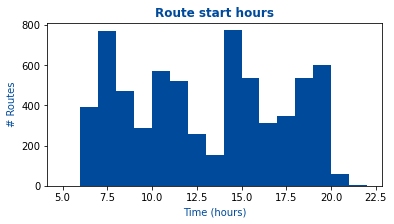

In [ ]:
site = site_data['site_id']
print(site)
# routes_site = routes[routes['site_id_start'] == site]
routes_site = routes
fig, ax = plt.subplots(
    1, figsize=(6, 3), gridspec_kw={'hspace': 0.5})
ax.set_title(
    'Route start hours',
    color=fps_colours[0], fontweight='bold')
ax.hist(
    routes_site['hour_starts'],
    np.arange(5, 23),
    color=[fps_colours[0]])

# ax.legend(frameon=False, bbox_to_anchor=(1, 0.8))
ax.set_ylabel('# Routes', color=fps_colours[0])
ax.set_xlabel('Time (hours)', color=fps_colours[0])